In [0]:
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import os
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
cd drive/My\ Drive/CS4774

/content/drive/My Drive/CS4774


In [0]:
cleaned_data = pd.read_csv('clean_data.csv')

In [0]:
LabelIsInjured = cleaned_data['Injury']
cleaned_data = cleaned_data.drop('Injury', axis = 1)

In [0]:
LabelFatalities = cleaned_data['Fatal_Crashes']
cleaned_data = cleaned_data.drop('Fatal_Crashes', axis = 1)

In [0]:
cleaned_data = cleaned_data.drop('Physical_Juris', axis = 1)
cleaned_data = cleaned_data.drop('PLAN_DISTRICT', axis = 1)

In [0]:
crashes_prepared = cleaned_data.to_numpy()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(crashes_prepared, np.asarray(LabelIsInjured), random_state=42)
#rnd_clf = RandomForestClassifier(n_estimators=50, random_state=42)
X_train_network, X_val_network, y_train_network, y_val_network = train_test_split(X_train, y_train, random_state=42, train_size = 0.75)

In [0]:
def createprobabilities(array):
  resultarray = []
  for i in range(len(array)):
    if(array[i]==1):
      resultarray.append([0,1])
    else:
      resultarray.append([1,0])
  return np.asarray(resultarray)

In [0]:
model = keras.Sequential()
model.add(keras.layers.Flatten(input_shape = [len(X_train[0])]))
model.add(keras.layers.Dense(250, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(130, activation='sigmoid'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(90, activation='sigmoid'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(2, activation='softmax'))
model.add(keras.layers.Reshape([2]))

In [0]:
model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])

In [0]:
y_train_net_prob = createprobabilities(y_train_network)
y_val_net_prob = createprobabilities(y_val_network)

In [15]:
model.fit(X_train_network, y_train_net_prob, batch_size=80, epochs = 15,
          validation_data=(X_val_network, y_val_net_prob))

Epoch 1/15
6284/6284 [==============================] - 27s 4ms/step - loss: 0.6445 - accuracy: 0.6562 - recall: 0.6562 - precision: 0.6562 - val_loss: 0.6441 - val_accuracy: 0.6557 - val_recall: 0.6557 - val_precision: 0.6557
Epoch 2/15
6284/6284 [==============================] - 26s 4ms/step - loss: 0.6436 - accuracy: 0.6565 - recall: 0.6565 - precision: 0.6565 - val_loss: 0.6448 - val_accuracy: 0.6557 - val_recall: 0.6557 - val_precision: 0.6557
Epoch 3/15
6284/6284 [==============================] - 26s 4ms/step - loss: 0.6434 - accuracy: 0.6565 - recall: 0.6565 - precision: 0.6565 - val_loss: 0.6439 - val_accuracy: 0.6557 - val_recall: 0.6557 - val_precision: 0.6557
Epoch 4/15
6284/6284 [==============================] - 27s 4ms/step - loss: 0.6434 - accuracy: 0.6565 - recall: 0.6565 - precision: 0.6565 - val_loss: 0.6438 - val_accuracy: 0.6557 - val_recall: 0.6557 - val_precision: 0.6557
Epoch 5/15
6284/6284 [==============================] - 25s 4ms/step - loss: 0.6434 - accura

In [0]:
injuries_pred_unfiltered = model.predict(X_test)
injuries_pred = np.argmax(injuries_pred_unfiltered, axis = 1)

In [17]:
auc = roc_auc_score(y_test, injuries_pred)
print(auc)

0.5


In [18]:
print("Recall: " + str(recall_score(y_test, injuries_pred)))
print("Precision: " + str(precision_score(y_test, injuries_pred)))
print("Accuracy: " + str(accuracy_score(y_test, injuries_pred)))

Recall: 0.0
Precision: 0.0
Accuracy: 0.6554185913273892


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


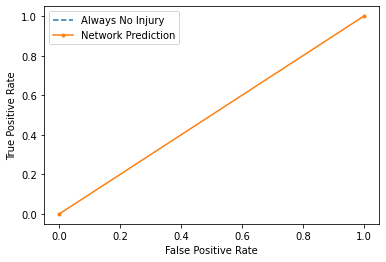

In [19]:
#Plots the ROC curve
blank_probs = [0 for _ in range(len(injuries_pred))]
blank_fpr, blank_tpr, _ = roc_curve(injuries_pred, blank_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, injuries_pred)
plt.plot(blank_fpr, blank_tpr, label = 'Always No Injury', linestyle='--')
plt.plot(nn_fpr, nn_tpr, label='Network Prediction', marker = '.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [0]:
index_fatal_w_inj = np.where(LabelIsInjured == 1)

In [0]:
fatal_subset_pd = cleaned_data.iloc[index_fatal_w_inj]

In [0]:
fatal_subset = fatal_subset_pd.to_numpy()

In [0]:
fatal_df = pd.DataFrame(LabelFatalities)

In [0]:
fatalities_label_subset_pd = fatal_df.iloc[index_fatal_w_inj]

In [0]:
fatalities_label_subset = fatalities_label_subset_pd.to_numpy()

In [26]:
print(len(fatal_subset))
print(len(fatalities_label_subset[0]))

307355
1


In [0]:
X_train_fatal, X_test_fatal, y_train_fatal, y_test_fatal = train_test_split(fatal_subset, fatalities_label_subset, random_state=42)
X_train_fatal_network, X_val_fatal_network, y_train_fatal_network, y_val_fatal_network = train_test_split(X_train_fatal, y_train_fatal, random_state=42, train_size = 0.75)

In [0]:
modelF = keras.Sequential()
modelF.add(keras.layers.Flatten(input_shape = [len(X_train_fatal[0])]))
modelF.add(keras.layers.Dense(200, activation='relu'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(180, activation='relu'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(155, activation='tanh'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(130, activation='tanh'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(100, activation='relu'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(75, activation='exponential'))
modelF.add(keras.layers.AlphaDropout(0.3))
modelF.add(keras.layers.Dense(40, activation='relu'))
modelF.add(keras.layers.AlphaDropout(0.2))
modelF.add(keras.layers.Dense(15, activation='relu'))
modelF.add(keras.layers.Dense(1,activation='sigmoid'))
modelF.add(keras.layers.Reshape([1]))

In [0]:
SGDoptimizer =keras.optimizers.SGD(learning_rate = 0.008, momentum = 0.9, nesterov = True)

In [0]:
modelF.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])

In [31]:
modelF.fit(X_train_fatal_network, y_train_fatal_network, batch_size=80, epochs = 15,
          validation_data=(X_val_fatal_network, y_val_fatal_network))

Epoch 1/15
2162/2162 [==============================] - 13s 6ms/step - loss: 0.1028 - accuracy: 0.9804 - recall_1: 0.0017 - precision_1: 0.0102 - val_loss: 0.0902 - val_accuracy: 0.9831 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/15
2162/2162 [==============================] - 13s 6ms/step - loss: 0.0893 - accuracy: 0.9831 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0864 - val_accuracy: 0.9831 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/15
2162/2162 [==============================] - 13s 6ms/step - loss: 0.0878 - accuracy: 0.9831 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0864 - val_accuracy: 0.9831 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 4/15
2162/2162 [==============================] - 13s 6ms/step - loss: 0.0872 - accuracy: 0.9831 - recall_1: 0.0000e+00 - precision_1: 0.0000e+00 - val_loss: 0.0859 - val_accuracy: 0.9831 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoc

In [0]:
fatal_pred = modelF.predict(X_test_fatal)

In [0]:
indexesoffatalities = np.where(fatal_pred >= 0.50)
almostpointlessdf = pd.DataFrame(np.asarray(indexesoffatalities))

In [0]:
fatal_pred = fatal_pred.astype(int)

In [35]:
confusion_matrix(y_test_fatal, fatal_pred)

array([[75554,     0],
       [ 1285,     0]])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


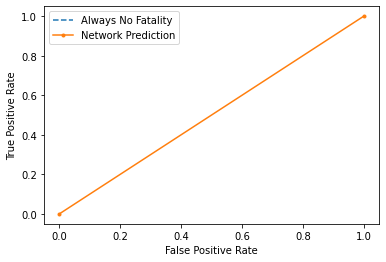

In [36]:
#Plots the ROC curve
blank_probs2 = [0 for _ in range(len(fatal_pred))]
blank_fpr2, blank_tpr2, _ = roc_curve(fatal_pred, blank_probs2)
nn_fprF, nn_tprF, _ = roc_curve(y_test_fatal, fatal_pred)
plt.plot(blank_fpr2, blank_tpr2, label = 'Always No Fatality', linestyle='--')
plt.plot(nn_fprF, nn_tprF, label='Network Prediction', marker = '.')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()